In [1]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
def get_legendre_coe(K):
    """
    Input:
        K: the highest order polynomial degree
    Return:
        P: (K+1, K+1), the coefficient matrix, where i-th column corresponds
            to i-th legendre polynomial's coefficients.
    """
    # initialize the first two coefficients
    P = [
        np.array([1] + [0] * K),
        np.array([0, 1] + [0] * (K - 1))
    ]
    for k in range(2, K + 1):
        P_k = np.zeros((K + 1,))
        P_k += (2 * k - 1) / k * np.roll(P[-1], 1) - (k - 1) / k * P[-2]
        P.append(P_k)

    return np.array(P).T


def generate_data(Qg, var, n):
    """
    Generate n data samples with Qg order legendre polynomial f and noise level var
    """
    x = np.random.uniform(-1, 1, (n,))
    epsilon = np.random.normal(0, np.sqrt(var), (n,))

    # get f
    normalize_factor = np.sqrt(np.sum([1 / (2 * q + 1) for q in range(Qg + 1)]))
    a = np.random.normal(size=(Qg + 1,)) / normalize_factor  # scale the variance of f to 1

    # get y
    Phi_x_Qg = np.vstack([np.power(x, i) for i in range(Qg + 1)]).T  # (n, Qg+1)
    P = get_legendre_coe(Qg)  # (Qg+1, Qg+1)
    y = Phi_x_Qg @ (P @ a) + epsilon

    return x, y, a


def calBestFitCoefficients(x, y, K):
    """
    calculate the best degree-K legendre polynomial that fits data (x, y)

    Return:
        w_star: (K+1, ), the best-fit coefficients
    """
    Lk = np.array([np.power(x, i) for i in range(K+1)]).T@get_legendre_coe(K)

    # Calculate the pseudo-inverse of Lk
    pseudo = np.linalg.inv(Lk.T @ Lk) @ Lk.T

    # Calculate the best-fit coefficients
    w_star = pseudo @ y
    return w_star


def calErout(w_star, a):
    """
    Input:
        w_star: (K+1, ), the best-fit coefficients
        a: (Qg+1, ), the true coefficients of the legendre polynomial
    Return:
        Erout: scalar, the out-of-sample error
    """
    K = w_star.shape[0] - 1
    Qg = a.shape[0] - 1
    normalize_factor = np.sqrt(np.sum([1 / (2 * q + 1) for q in range(Qg + 1)]))

    # Calculate the minimum degree
    min_degree = min(K, Qg)

    # Calculate the first term
    first = np.sum(w_star ** 2 * np.array([1 / (2 * k + 1) for k in range(K + 1)]))

    # Calculate the second term
    second = -2 * (np.sum(w_star[:min_degree] * a[:min_degree] *
                          np.array([1 / (2 * i + 1) for i in range(min_degree)])) / normalize_factor)

    # Calculate the third term
    third = (np.sum(a ** 2 * np.array([1 / (2 * q + 1) for q in range(Qg + 1)])) / normalize_factor ** 2)

    # Calculate the out-of-sample error
    Erout = 2 * (first + second + third)
    return Erout

#### 1) fix $\sigma^2$ = 0.1, vary $Q_g \in \{1, 2, \dots, 50\} $ and $n \in \{20, 25, \dots, 120\}$

In [3]:
repeat_num = 40
ns = np.arange(20, 120, 5)
vars = 0.1
Qg = np.arange(1, 51, 1)

logs = {
    "Erout_10": np.zeros((len(ns), len(Qg))),
    "Erout_2": np.zeros((len(ns), len(Qg))),
    "overfit_measure": np.zeros((len(ns), len(Qg))),
}

i, j = 0, 0
for qg, n in product(Qg, ns):
    Erin_10, Erin_2 = 0, 0
    Erout_10, Erout_2 = 0, 0
    for _ in range(repeat_num):
        x, y, a = generate_data(qg, vars, n)
        w_star_10 = calBestFitCoefficients(x, y, 10)
        w_star_2 = calBestFitCoefficients(x, y, 2)

        Erout_10 += calErout(w_star_10, a) / repeat_num
        Erout_2 += calErout(w_star_2, a) / repeat_num

    overfit_measure = Erout_10 - Erout_2
    logs["Erout_10"][i,j] = Erout_10
    logs["Erout_2"][i,j] = Erout_2
    logs["overfit_measure"][i,j] = overfit_measure

    i += 1
    if i == len(ns):
        i = 0
        j += 1

# clip for better plot view
for key in logs:
    logs[key] = np.clip(logs[key], -0.2, 2)

In [4]:
# optimal coefficients for f2 and f10
print('optimal coefficients for f2:', w_star_2)
print('optimal coefficients for f10:', w_star_10)

optimal coefficients for f2: [-0.0942491   0.25375951 -0.35456573]
optimal coefficients for f10: [-0.03708723 -0.22320273 -0.17029007 -0.28674751  0.27100204  1.91277517
  0.30512317  2.34686543 -0.85413911  1.94162958 -2.2331006 ]


In [5]:
# the out-of-sample error for f2
logs["Erout_2"]

array([[0.86195676, 0.44638413, 0.74601786, 0.68235192, 0.81513104,
        0.97628191, 0.84656805, 0.76514982, 0.79393856, 1.01488441,
        0.92037201, 1.02905757, 1.11156904, 1.12992083, 1.02826785,
        0.99255839, 0.81723866, 0.77632715, 0.7663836 , 0.94113859,
        0.92310804, 0.90279058, 0.94474876, 0.76691814, 0.97089417,
        0.8531375 , 1.31794905, 1.03077938, 0.99909402, 1.07229362,
        0.95872781, 1.14317679, 0.97638935, 0.92471593, 0.94167035,
        0.95989747, 0.98173516, 0.87830035, 0.94386777, 0.94646339,
        1.08215714, 1.15087749, 0.75548005, 0.96702857, 0.93471035,
        1.05591324, 0.97502821, 1.08749065, 2.        , 2.        ],
       [0.95303986, 0.48728853, 0.59488477, 0.72467395, 0.69950569,
        0.7225109 , 0.73892034, 0.69687301, 0.7587811 , 0.8739443 ,
        0.67462674, 0.84431504, 0.65930934, 0.84556467, 0.96584369,
        0.91231395, 0.86920194, 0.84097432, 0.82428934, 0.84168275,
        0.69852201, 0.79270452, 0.85419522, 0.7

In [6]:
# the out-of-sample error for f10
logs["Erout_10"]

array([[2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ],
       [2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2.        , 2.        ,
        2.        , 2.        , 2.        , 2. 

In [7]:
# the overfit measure
logs["overfit_measure"]

array([[ 2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00,  2.00000000e+00,
         2.00000000e+00,  2.00000000e+00],
       [ 2.00

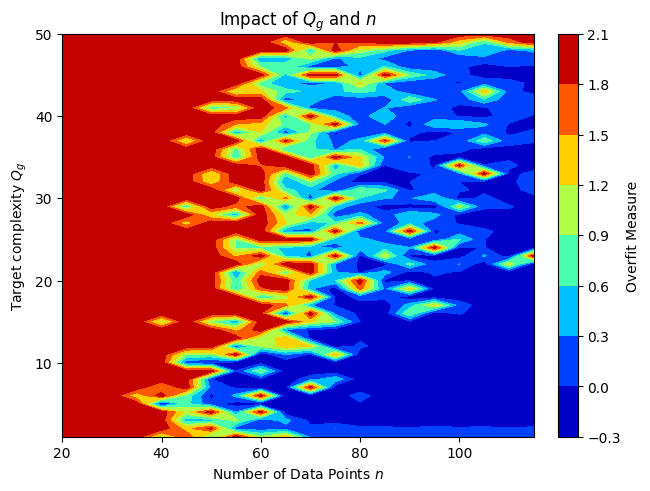

In [8]:
# plot
cmap = plt.colormaps.get_cmap("jet")

fig1, ax2 = plt.subplots(constrained_layout=True)
Qf_mesh, n_mesh = np.meshgrid(Qg, ns)
CS = ax2.contourf(n_mesh.T, Qf_mesh.T, logs["overfit_measure"].T, cmap=cmap)
ax2.set_title('Impact of $Q_g$ and $n$')
ax2.set_xlabel('Number of Data Points $n$')
ax2.set_ylabel('Target complexity $Q_g$')

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Overfit Measure')
N = cmap.N
CS.cmap.set_under(cmap(1))
CS.cmap.set_over(cmap(N - 1))

plt.savefig("overfit_sigma_vs_n.pdf")
plt.show()

### 2) fix $Q_g$ = 20, vary $\sigma$ and n

In [9]:
repeat_num = 100
ns = np.arange(20, 120, 5)
vars = np.arange(0, 2, 0.05)

logs = {
    "Erout_10": np.zeros((len(ns), len(vars))),
    "Erout_2": np.zeros((len(ns), len(vars))),
    "overfit_measure": np.zeros((len(ns), len(vars))),
}

Qg = 20
i, j = 0, 0
for var, n in product(vars, ns):
    Erin_10, Erin_2 = 0, 0
    Erout_10, Erout_2 = 0, 0
    for _ in range(repeat_num):
        x, y, a = generate_data(Qg, var, n)
        w_star_10 = calBestFitCoefficients(x, y, 10)
        w_star_2 = calBestFitCoefficients(x, y, 2)

        Erout_10 += calErout(w_star_10, a) / repeat_num
        Erout_2 += calErout(w_star_2, a) / repeat_num

    overfit_measure = Erout_10 - Erout_2
    logs["Erout_10"][i, j] = Erout_10
    logs["Erout_2"][i, j] = Erout_2
    logs["overfit_measure"][i, j] = overfit_measure

    i += 1
    if i == len(ns):
        i = 0
        j += 1

# clip for better plot view
for key in logs:
    logs[key] = np.clip(logs[key], -1, 10)

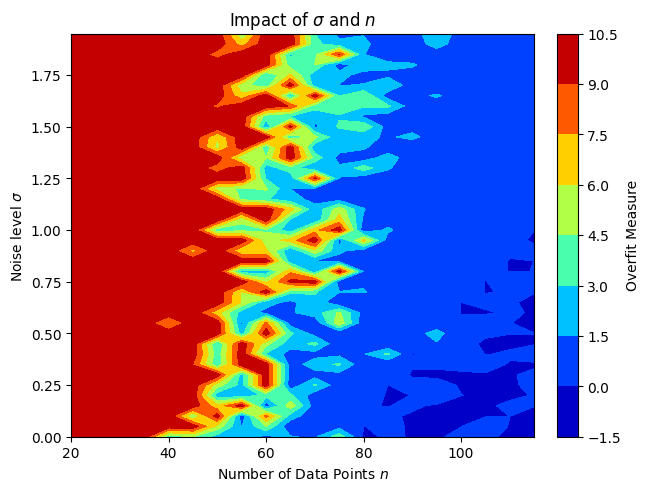

In [10]:
# plot
cmap = plt.colormaps.get_cmap("jet")

fig1, ax2 = plt.subplots(constrained_layout=True)
Qf_mesh, n_mesh = np.meshgrid(vars, ns)
CS = ax2.contourf(n_mesh.T, Qf_mesh.T, logs["overfit_measure"].T, cmap=cmap)
ax2.set_title('Impact of $\\sigma$ and $n$')
ax2.set_xlabel('Number of Data Points $n$')
ax2.set_ylabel('Noise level $\\sigma$')

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('Overfit Measure')
N = cmap.N
CS.cmap.set_under(cmap(1))
CS.cmap.set_over(cmap(N - 1))

plt.savefig("overfit_sigma_vs_n.pdf")
plt.show()